In [44]:
!pip install --user lightgbm

  Using cached https://files.pythonhosted.org/packages/77/0f/5157e6b153b3d4a70dc5fbe2ab6f209604197590f387f03177b7a249ac60/lightgbm-2.2.3-py2.py3-none-manylinux1_x86_64.whl
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from datetime import datetime, date

from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

sns.set()
%matplotlib inline

In [3]:
data = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                   parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                   low_memory=False, na_values=['nan','?'], index_col='dt')

In [4]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
# first_day = data[data.index.date == date(2009, 12, 16)]

In [7]:
# second_day = data[data.index.date == date(2009, 12, 17)]

In [8]:
# plt.figure(figsize=(16,9))
# sns.lineplot(data=first_day.iloc[:, 0])

In [9]:
# plt.figure(figsize=(16,9))
# sns.lineplot(data=second_day.iloc[:, 0])

In [10]:
# for j in range(0,7):        
#         data.iloc[:,j]=data.iloc[:,j].fillna(data.iloc[:,j].mean())

## Exploratory data analysis

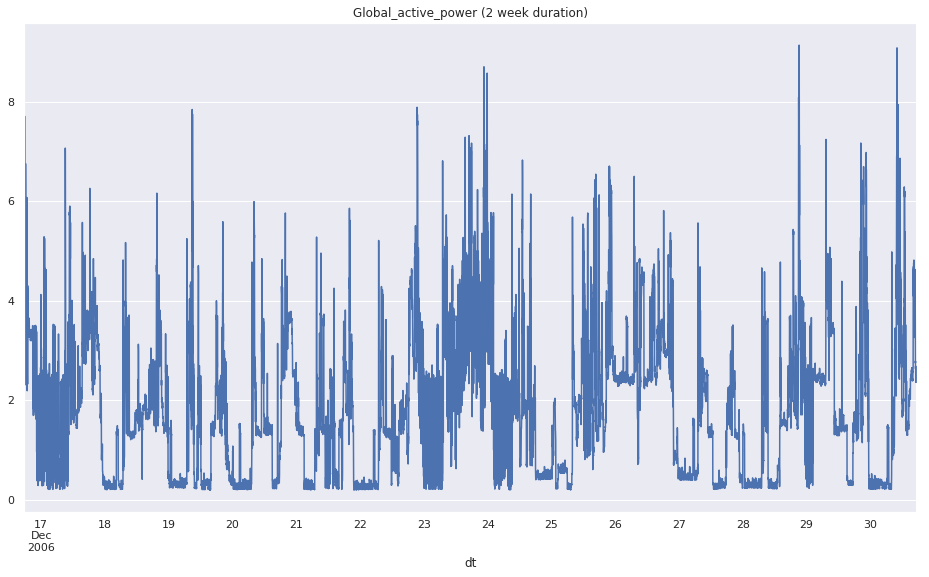

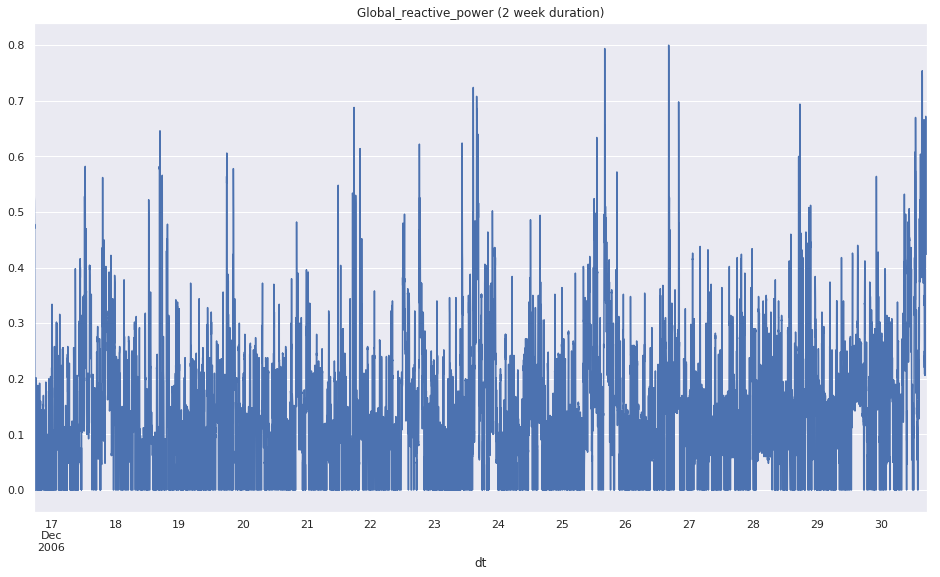

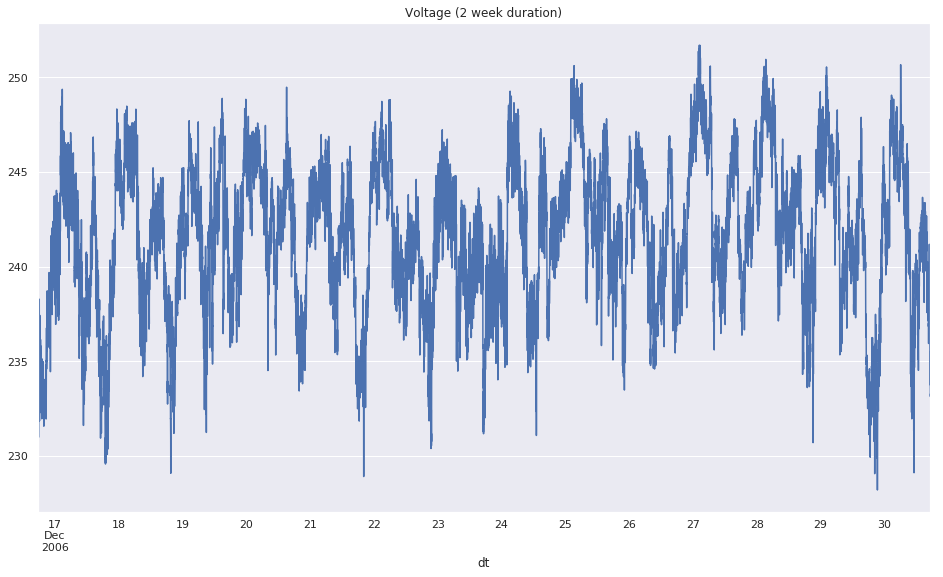

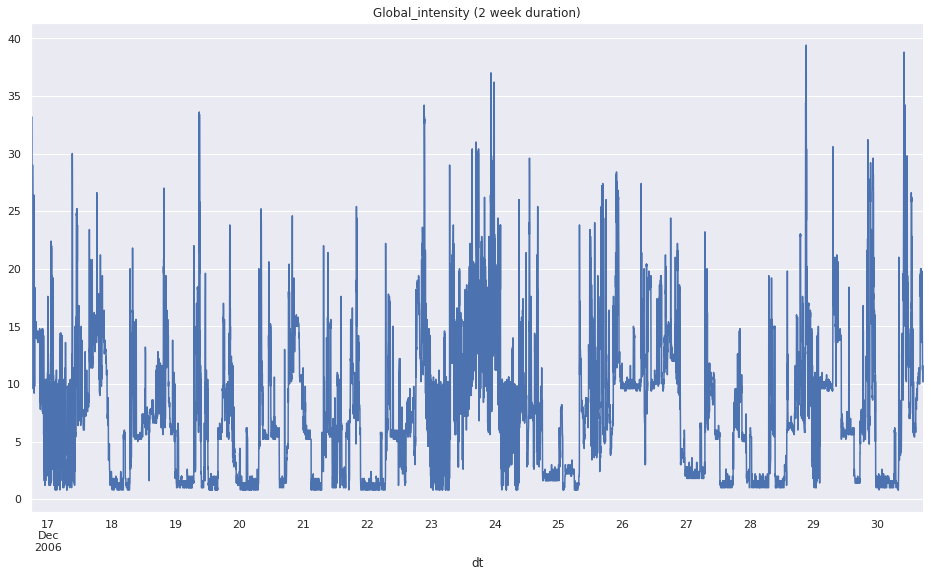

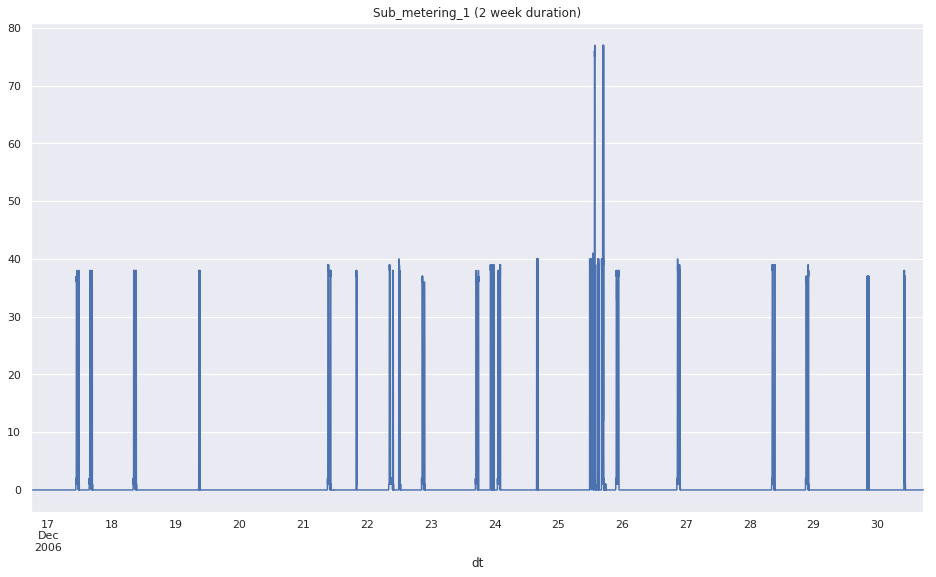

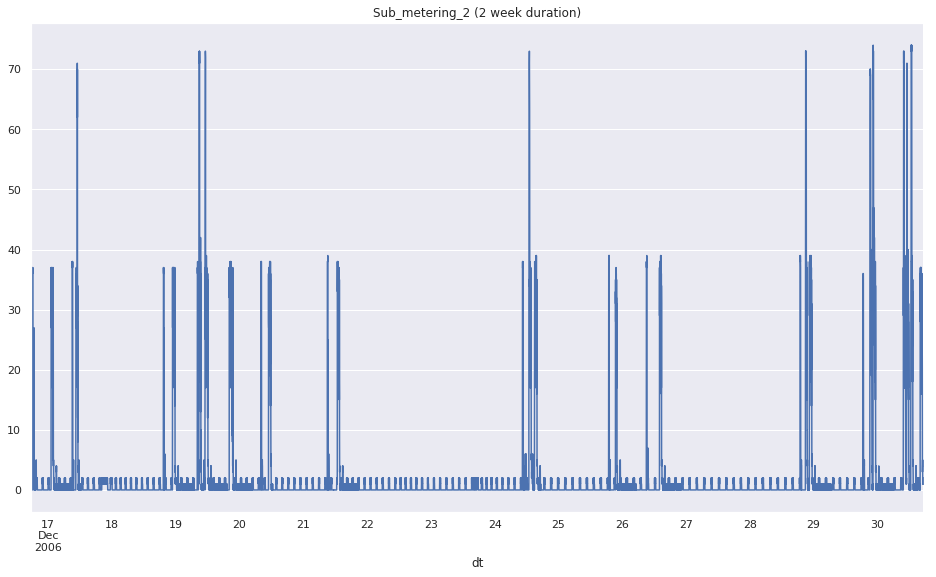

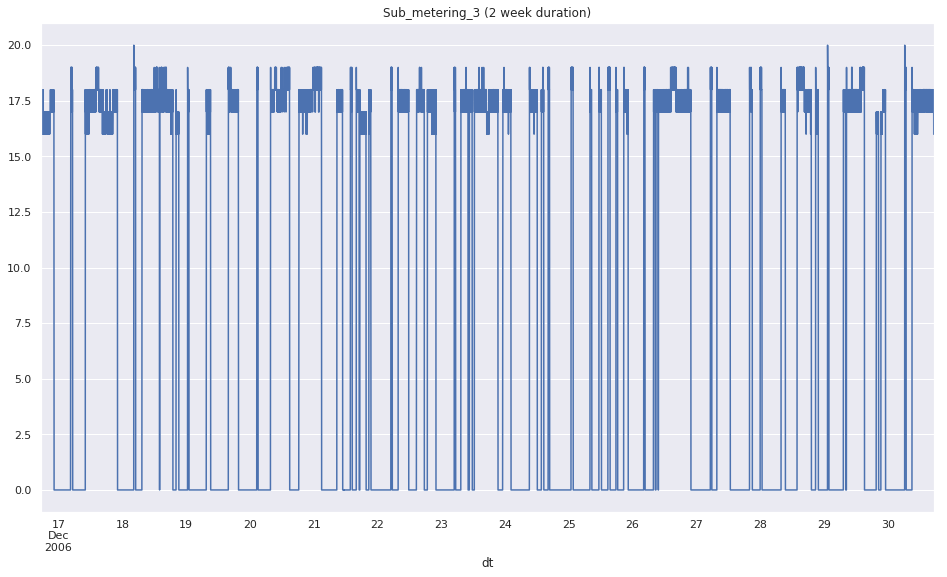

In [11]:
for column in data.columns:
    plt.figure(figsize=(16, 9))
    plt.title(f'{column} (2 week duration)')
    data[column][:60*24*14].plot()
    plt.show()

Для простоты будем работать с **дневным** потреблением электричества (*Global active power*), посмотрим внимательнее на данные.

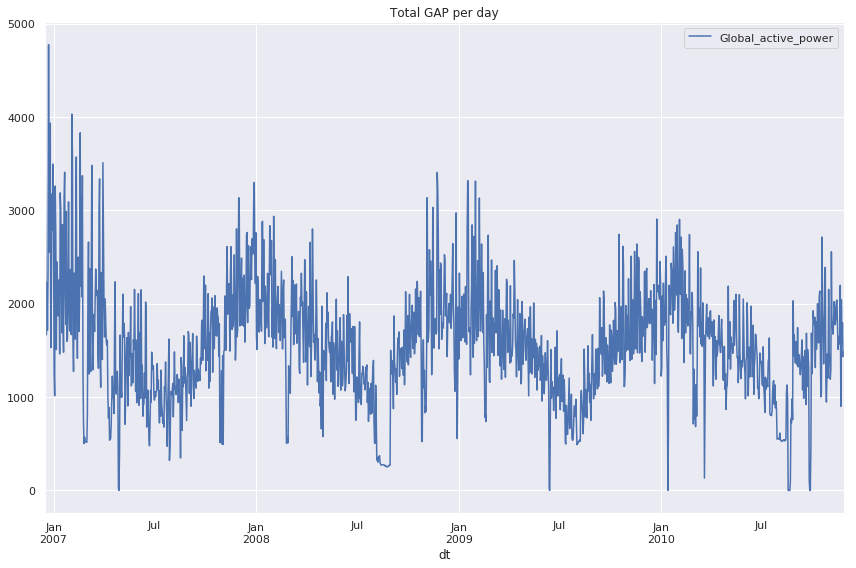

In [12]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

Видим несколько пиков в нуле. Достаточно странное поведение, учитывая что мы суммировали все возможные значения мощности за день. Посмотрим на изначальные данные.

In [13]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

В данных пропусков примерно на 18 дней, интерполируем пропущенные значения.

In [14]:
data.interpolate(method='time', inplace=True)
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [15]:
data['Global_active_power'].describe()

count    2.075259e+06
mean     1.090280e+00
std      1.052628e+00
min      7.600000e-02
25%      3.100000e-01
50%      6.140000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

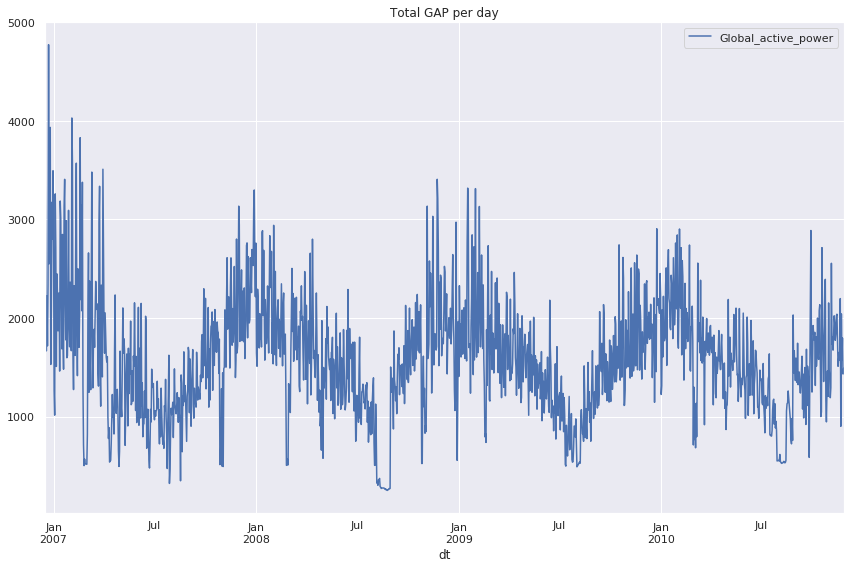

In [16]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

In [17]:
# r = data['Global_active_power'].resample('D').agg(['mean', 'std'])
# r.plot(subplots=True, title='GAP resampled over day', figsize=(12, 8))
# plt.tight_layout()
# plt.show()

## Таск: Придумать простые бейзлайн решения для прогнозирования рядов (сегодня будет так же как вчера, скользящее среднее и т.п.)

# Fbprophet

Prophet был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, он дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.

Из минусов можно отметить достаточно небольшую точность предсказания "из коробки", для повышения качества придется повозиться с настройкой параметров. А так же странную работу (или отсутствие работы) с нестандартными периодами данных, например с часовыми тиками.

[Статья](https://research.fb.com/prophet-forecasting-at-scale/) от Facebook про Prophet.  
[Ссылка](https://facebook.github.io/prophet/docs/quick_start.html) на официальную документацию.

In [18]:
from fbprophet import Prophet

Библиотека **Prophet** имеет интерфейс похожий на *sklearn*, сначала мы создаем модель, затем вызываем у нее метод *fit* для тренировки и *predict* для предсказания. На вход методу *fit* библиотека принимает *dataframe* с двумя колонками:

**ds** — время, поле должно быть типа date или datetime,  
**y** — числовой показатель, который мы хотим предсказывать.

In [19]:
prediction_size = 31

df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [20]:
train_df = df[:-prediction_size]

In [21]:
model = Prophet(daily_seasonality=True)
model.fit(train_df)

/home/control/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead



Для того что бы построить предсказания методу *predict* нужно передать *dataframe* с количеством записей, равным периоду, на который нужно предсказать.

In [22]:
future_dataframe = model.make_future_dataframe(periods=prediction_size, freq='D')
future_dataframe.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [23]:
forecast = model.predict(future_dataframe)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,1256.592878,1455.002592,2514.520911,1256.514432,1256.693236,753.981302,753.981302,753.981302,347.387396,...,-130.351356,-130.351356,-130.351356,536.945263,536.945263,536.945263,0.0,0.0,0.0,2010.574180
1438,2010-11-23,1256.689284,1548.939465,2684.005575,1256.601053,1256.802503,870.111966,870.111966,870.111966,347.387396,...,-19.285752,-19.285752,-19.285752,542.010322,542.010322,542.010322,0.0,0.0,0.0,2126.801250
1439,2010-11-24,1256.785690,1591.403914,2665.815560,1256.690979,1256.905055,887.012466,887.012466,887.012466,347.387396,...,-3.948141,-3.948141,-3.948141,543.573212,543.573212,543.573212,0.0,0.0,0.0,2143.798156
1440,2010-11-25,1256.882096,1459.067243,2529.591093,1256.775743,1257.007474,728.828080,728.828080,728.828080,347.387396,...,-160.452695,-160.452695,-160.452695,541.893380,541.893380,541.893380,0.0,0.0,0.0,1985.710176
1441,2010-11-26,1256.978501,1530.653372,2584.998377,1256.858654,1257.112491,817.456432,817.456432,817.456432,347.387396,...,-67.231791,-67.231791,-67.231791,537.300828,537.300828,537.300828,0.0,0.0,0.0,2074.434933


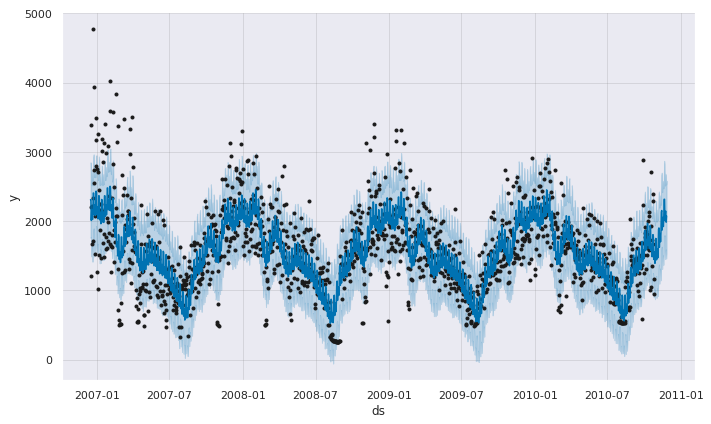

In [24]:
model.plot(forecast);

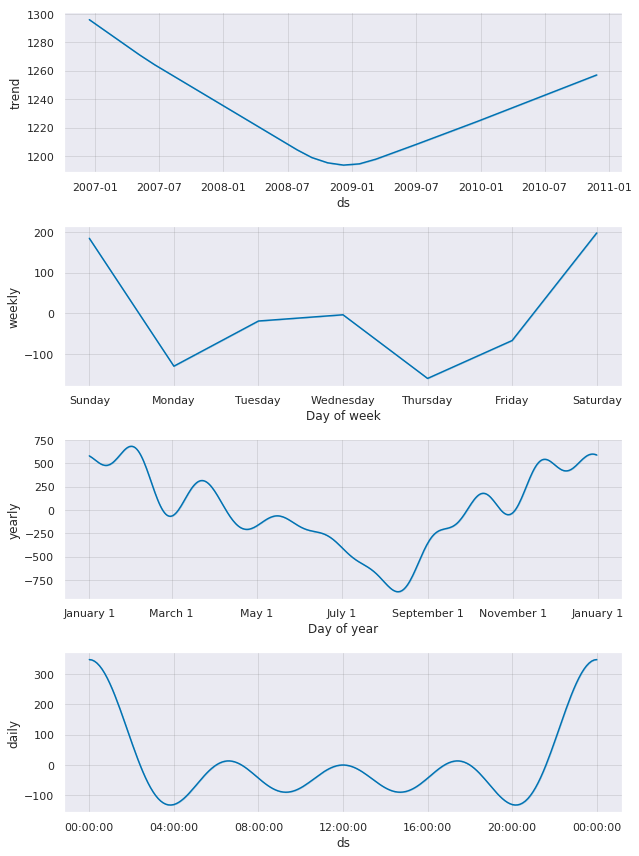

In [25]:
model.plot_components(forecast);

### Посчитаем ошибки прогноза:
MAPE (mean absolute percentage error) — это средняя абсолютная ошибка нашего прогноза. MAPE часто используется для оценки качества, поскольку эта величина относительная и по ней можно сравнивать качество даже на различных наборах данных.

$y_i$ - значение ряда в момент времени $i$.  
$\hat{y_i}$ - прогноз нашей модели в то же время.  

$e_i = y_i - \hat{y_i}$ - ошибка прогноза.  
$p_i = \frac{e_i}{y_i}$ - относительная ошибка прогноза.

$MAE = mean\space (\mid{e_i}\mid)$  
$MAPE = mean\space (\mid{p_i}\mid)$

In [26]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [27]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
       Return:
           tuple: (MAPE, MAE)
    """
    
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return error_mean('p'), error_mean('e')

In [28]:
cmp_df = make_comparison_dataframe(df, forecast)
mape, mae = calculate_forecast_errors(cmp_df, prediction_size)
print(f'MAPE = {mape},\nMAE = {mae}')

MAPE = 21.77352971197422,
MAE = 319.97705686656184


In [29]:
def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)

In [30]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='y'), title=title, showlegend=True)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [31]:
show_forecast(cmp_df, prediction_size, 140, 'Prediction')

## Преобразование Бокса-Кокса

Это монотонное преобразование для данных, которое обычно используется для стабилизации дисперсии. Подробнее [здесь.](https://en.wikipedia.org/wiki/Power_transform) 

Для исходной последовательности $y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$ однопараметрическое преобразование Бокса-Кокса с параметром $\lambda$ определяется следующим образом:

$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda-1}{\lambda},&\text{if } \lambda \neq 0,\\ \log{(y_i)},& \text{if } \lambda = 0.\end{cases}$

Параметр $\lambda$ можно выбирать, максимизируя логарифм правдоподобия. Еще один способ поиска оптимального значения параметра основан на поиске максимальной величины коэффициента корреляции между квантилями функции нормального распределения и отсортированной преобразованной последовательностью.

In [32]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [33]:
df_with_boxcox = df.copy().set_index('ds')
df_with_boxcox['y'], lambda_ = stats.boxcox(df_with_boxcox['y'])
df_with_boxcox.reset_index(inplace=True)

In [34]:
pd.concat([df_with_boxcox, df.y], axis=1).head()

,ds,y,y
0,2006-12-16,168.598628,1209.176
1,2006-12-17,336.676585,3390.460
2,2006-12-18,252.276815,2203.826
3,2006-12-19,209.121696,1666.194
4,2006-12-20,253.956562,2225.748


In [35]:
train_df_wb = df_with_boxcox[:-prediction_size]

model_wb = Prophet(daily_seasonality=True)
model_wb.fit(train_df_wb)

In [36]:
future_df_wb = model_wb.make_future_dataframe(periods=prediction_size, freq='D')
future_df_wb.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [37]:
forecast_wb = model_wb.predict(future_df_wb)
forecast_wb.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,174.650488,194.421223,287.725342,174.643395,174.657496,63.445583,63.445583,63.445583,27.024764,...,-10.676995,-10.676995,-10.676995,47.097814,47.097814,47.097814,0.0,0.0,0.0,238.096071
1438,2010-11-23,174.660136,199.339117,293.754028,174.651779,174.667832,73.338574,73.338574,73.338574,27.024764,...,-1.315032,-1.315032,-1.315032,47.628842,47.628842,47.628842,0.0,0.0,0.0,247.998710
1439,2010-11-24,174.669783,202.799023,296.734208,174.660665,174.678345,74.976195,74.976195,74.976195,27.024764,...,0.106383,0.106383,0.106383,47.845048,47.845048,47.845048,0.0,0.0,0.0,249.645979
1440,2010-11-25,174.679431,186.877643,279.534789,174.669554,174.688587,61.412692,61.412692,61.412692,27.024764,...,-13.378964,-13.378964,-13.378964,47.766892,47.766892,47.766892,0.0,0.0,0.0,236.092123
1441,2010-11-26,174.689079,198.951958,292.421394,174.678079,174.698626,69.475486,69.475486,69.475486,27.024764,...,-4.970501,-4.970501,-4.970501,47.421223,47.421223,47.421223,0.0,0.0,0.0,244.164565


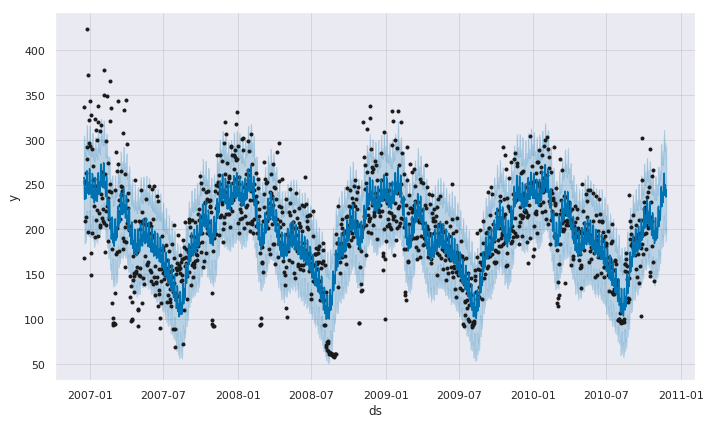

In [38]:
model_wb.plot(forecast_wb);

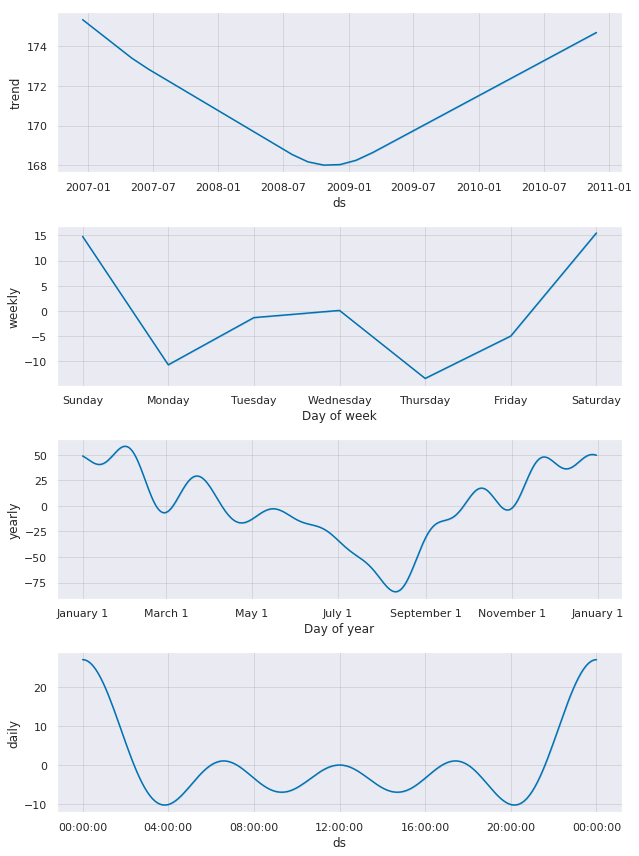

In [39]:
model_wb.plot_components(forecast_wb);

In [40]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_wb[column] = inverse_boxcox(forecast_wb[column], lambda_)

In [41]:
cmp_df_wb = make_comparison_dataframe(df, forecast_wb)
mape_wb, mae_wb = calculate_forecast_errors(cmp_df_wb, prediction_size)
print(f'MAPE = {mape:.2f}, MAPE with Box-Cox = {mape_wb:.2f}')
print(f'MAE = {mae:.2f}, MAE with Box-Cox = {mae_wb:.2f}')

MAPE = 21.77, MAPE with Box-Cox = 21.89
MAE = 319.98, MAE with Box-Cox = 322.91


In [42]:
show_forecast(cmp_df, prediction_size, 140, f'Prediction without transformation (MAPE = {mape:.2f})')
show_forecast(cmp_df_wb, prediction_size, 140, f'Prediction after Box-Cox (MAPE = {mape_wb:.2f})')

# LightGBM

In [45]:
import lightgbm as lgb

**LightGBM** это одна из самых популярных библиотек для градиентного бустинга. Основные её преимущества в том, что она эффективна по памяти и действительно быстрая (бонусом идёт возможность работать с большими массивами данных и sparse матрицами).

[Ссылка](https://lightgbm.readthedocs.io/en/latest/) на официальную документацию.

In [46]:
def mean_encoding(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [47]:
def prepare_df(data, target_column, lag_start=1, lag_end=2, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for column in data.columns:
        for i in range(lag_start, lag_end):
            data[f"{column}_t-{i}"] = data[column].shift(i)
        if column != target_column:
            data.drop(column, axis=1, inplace=True)
        
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data[f'{target_column}_weekday_average'] = list(map(mean_encoding(data[:test_index], 'weekday',
                                                                      target_column).get, data.weekday))
    data[f"{target_column}_hour_average"] = list(map(mean_encoding(data[:test_index], 'hour',
                                                                   target_column).get, data.hour))

    # выкидываем закодированные средними признаки
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target_column], axis=1)
    y_train = data.loc[:test_index][target_column]
    X_test = data.loc[test_index:].drop([target_column], axis=1)
    y_test = data.loc[test_index:][target_column]
    
    return X_train, X_test, y_train, y_test

## Таск: придумать признаки для модели

In [48]:
X_train, X_test, y_train, y_test = prepare_df(data.resample('D').apply(sum),
                                              "Global_active_power",
                                              lag_end=7,
                                              test_size=0.15)

In [49]:
X_train.head()

,Global_active_power_t-1,Global_active_power_t-2,Global_active_power_t-3,Global_active_power_t-4,Global_active_power_t-5,Global_active_power_t-6,Global_reactive_power_t-1,Global_reactive_power_t-2,Global_reactive_power_t-3,Global_reactive_power_t-4,...,Sub_metering_2_t-6,Sub_metering_3_t-1,Sub_metering_3_t-2,Sub_metering_3_t-3,Sub_metering_3_t-4,Sub_metering_3_t-5,Sub_metering_3_t-6,is_weekend,Global_active_power_weekday_average,Global_active_power_hour_average
0,1717.114,2225.748,1666.194,2203.826,3390.460,1209.176,144.166,160.998,150.942,161.792,...,546.0,10421.0,14063.0,6197.0,14018.0,13341.0,4926.0,0,1530.553291,1603.321093
1,2341.338,1717.114,2225.748,1666.194,2203.826,3390.460,186.906,144.166,160.998,150.942,...,4187.0,11131.0,10421.0,14063.0,6197.0,14018.0,13341.0,1,1826.550886,1603.321093
2,4773.386,2341.338,1717.114,2225.748,1666.194,2203.826,221.470,186.906,144.166,160.998,...,2621.0,14726.0,11131.0,10421.0,14063.0,6197.0,14018.0,1,1800.185244,1603.321093
3,2550.012,4773.386,2341.338,1717.114,2225.748,1666.194,149.900,221.470,186.906,144.166,...,7602.0,6891.0,14726.0,11131.0,10421.0,14063.0,6197.0,0,1453.988602,1603.321093
4,2743.120,2550.012,4773.386,2341.338,1717.114,2225.748,240.280,149.900,221.470,186.906,...,2648.0,5795.0,6891.0,14726.0,11131.0,10421.0,14063.0,0,1583.114485,1603.321093


In [50]:
# Логарифмируем таргет (частный случай преобразования Бокса-Кокса)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [51]:
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_test = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

In [52]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.005,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                verbose_eval=False,
                valid_sets=lgb_test,
                num_boost_round=10000,
                early_stopping_rounds=50)

## Таск: реализовать функции для подсчёта MAE, MAPE

In [53]:
def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [54]:
def mean_abs_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
# Не забываем про обратное преобразование
y_pred = np.exp(gbm.predict(X_test))

# Сравним с наивным бейзлайном "завтра будет так же, как сегодня"
y_naive_pred = y_test.shift(1)

print(f'GBM MAE = {mean_abs_error(y_test, y_pred)}')
print(f'GBM MAPE = {mean_abs_percentage_error(y_test, y_pred)}\n')
print(f'Naive MAE = {mean_abs_error(y_test, y_naive_pred)}')
print(f'Naive MAPE = {mean_abs_percentage_error(y_test, y_naive_pred)}')

GBM MAE = 246.44262082982638
GBM MAPE = 19.277422429811345

Naive MAE = 281.0934185248244
Naive MAPE = 19.962637687670366


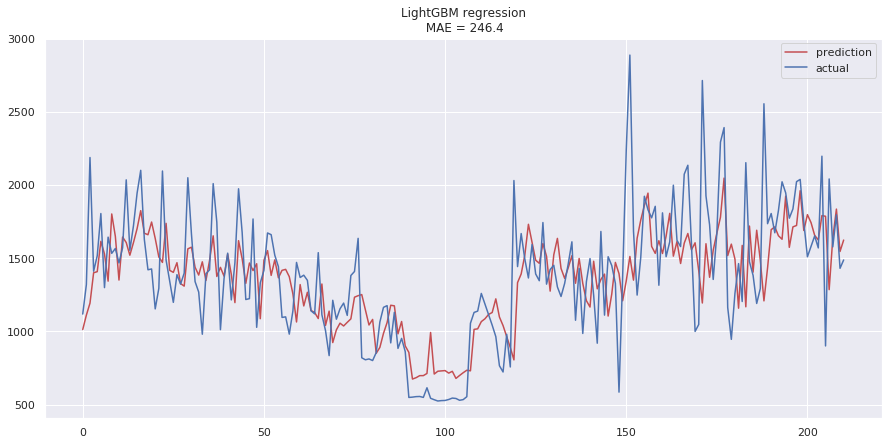

In [56]:
plt.figure(figsize=(15, 7))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual", alpha=0.99)
plt.legend(loc="best")
plt.title(f"LightGBM regression\n MAE = {mean_abs_error(y_test, y_pred):.1f}")
plt.grid(True);